-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from numpy import mean
from numpy import std
import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [4]:
df_input = pd.read_csv('df_combine_20240601.csv')
df_input['num_vesicles'] = np.ceil(df_input['num_vesicles']).astype(int)
df_input

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,0.460,0.420,0.995,0.960,0.945,0.3000,0.795,0,0.000000,0.000000
1,0.815,0.720,0.865,0.845,0.925,0.1890,0.225,0,0.000000,0.000000
2,0.855,0.400,0.990,0.930,0.835,0.2490,0.570,0,0.000000,0.000000
3,0.720,0.555,0.540,0.800,0.875,0.1200,0.685,0,0.000000,0.000000
4,0.785,0.044,0.900,0.875,0.780,0.0555,0.860,0,0.000000,0.000000
5,0.715,1.000,0.565,0.920,0.610,0.1245,0.980,0,0.000000,0.000000
6,0.780,0.360,0.895,0.870,0.865,0.3450,0.975,0,0.000000,0.000000
7,0.605,0.765,0.335,0.865,0.970,0.2700,0.785,0,0.000000,0.000000
8,0.550,0.910,0.670,0.585,0.910,0.0540,0.885,0,0.000000,0.000000
9,0.470,0.340,0.790,0.995,0.870,0.0285,0.425,0,56.745017,0.000054


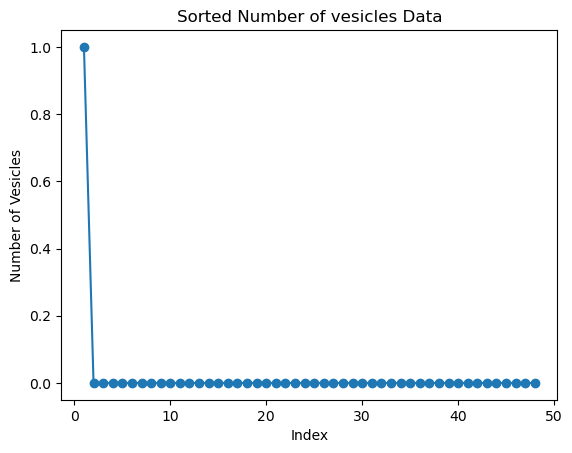

In [12]:
# Sort the DataFrame based on the "area_percent" column
df_sorted = df_input.sort_values(by="num_vesicles", ascending=False)

# Plot the sorted data
plt.plot(range(1, len(df_sorted) + 1), df_sorted["num_vesicles"], marker='o')
plt.xlabel("Index")
plt.ylabel("Number of Vesicles")
plt.title("Sorted Number of vesicles Data")
plt.show()

In [14]:
len(df_input[df_input['num_vesicles']>0])/48

0.020833333333333332

In [5]:
# Apply log1p transformation to each value in the DataFrame
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_43128/2331498562.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.378436,0.350657,0.690644,0.672944,0.665262,0.262364,0.585005,0
1,0.596085,0.542324,0.623261,0.612479,0.654926,0.173113,0.202941,0
2,0.617885,0.336472,0.688135,0.657520,0.607044,0.222343,0.451076,0
3,0.542324,0.441476,0.431782,0.587787,0.628609,0.113329,0.521766,0
4,0.579418,0.043059,0.641854,0.628609,0.576613,0.054015,0.620576,0
5,0.539413,0.693147,0.447886,0.652325,0.476234,0.117338,0.683097,0
6,0.576613,0.307485,0.639219,0.625938,0.623261,0.296394,0.680568,0
7,0.473124,0.568151,0.288931,0.623261,0.678034,0.239017,0.579418,0
8,0.438255,0.647103,0.512824,0.460584,0.647103,0.052592,0.633928,0
9,0.385262,0.292670,0.582216,0.690644,0.625938,0.028101,0.354172,0


In [16]:
df_input.to_csv('../../data/20240531/df_input_20240601.csv', index=False)

In [6]:
df_input_init = pd.read_csv('../../data/20240523/df_input_update_20240526.csv')

In [7]:
df_input_update = pd.concat([df_input_init, df_input])
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
43,0.395415,0.623261,0.177309,0.654926,0.680568,0.088926,0.408793,0
44,0.631272,0.685619,0.347130,0.506818,0.598837,0.026642,0.454255,0
45,0.542324,0.405465,0.585005,0.690644,0.533565,0.146263,0.576613,0
46,0.660107,0.518794,0.470004,0.657520,0.657520,0.465305,0.601580,0


In [20]:
df_input_update.to_csv('../../data/20240531/df_input_update_20240601.csv', index = False)

In [2]:
df_input_update = pd.read_csv('../../data/20240531/df_input_update_20240601.csv')

In [3]:
# Input for classification model
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
235,0.395415,0.623261,0.177309,0.654926,0.680568,0.088926,0.408793,0
236,0.631272,0.685619,0.347130,0.506818,0.598837,0.026642,0.454255,0
237,0.542324,0.405465,0.585005,0.690644,0.533565,0.146263,0.576613,0
238,0.660107,0.518794,0.470004,0.657520,0.657520,0.465305,0.601580,0


In [4]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

Iteration 1: Training Accuracy = 0.9062, Test Accuracy = 0.9167
Iteration 2: Training Accuracy = 0.8854, Test Accuracy = 0.8750
Iteration 3: Training Accuracy = 0.9427, Test Accuracy = 0.7708
Iteration 4: Training Accuracy = 0.9167, Test Accuracy = 0.9167
Iteration 5: Training Accuracy = 0.9062, Test Accuracy = 0.8542
Iteration 6: Training Accuracy = 0.9271, Test Accuracy = 0.8333
Iteration 7: Training Accuracy = 0.9219, Test Accuracy = 0.8333
Iteration 8: Training Accuracy = 0.8906, Test Accuracy = 0.9375
Iteration 9: Training Accuracy = 0.8802, Test Accuracy = 0.8958
Iteration 10: Training Accuracy = 0.9062, Test Accuracy = 0.8333

Average Training Accuracy: 0.9083
Training Accuracy Standard Deviation: 0.0185
Average Test Accuracy: 0.8667
Test Accuracy Standard Deviation: 0.0486


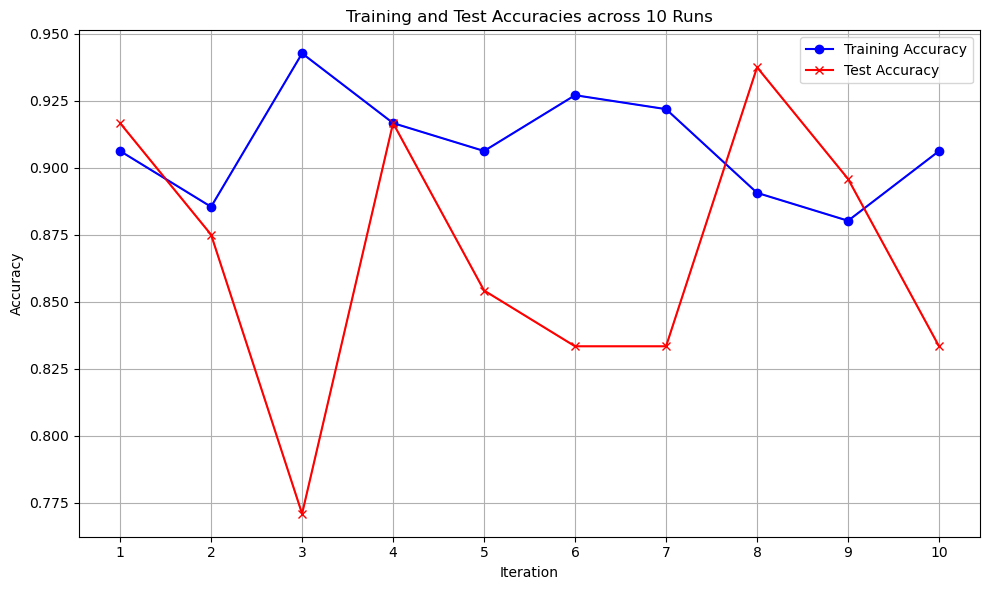

In [5]:
train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate the average and standard deviation of training and testing accuracies
average_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Training Accuracy: {average_train_accuracy:.4f}")
print(f"Training Accuracy Standard Deviation: {std_train_accuracy:.4f}")
print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"Test Accuracy Standard Deviation: {std_test_accuracy:.4f}")


# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# working on whole dagtaset to get final model
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)

model.score(X, y)

0.9083333333333333

In [11]:
# Save the model to a file
with open('../../data/20240531/model/GPC_model_20240601.pkl', 'wb') as file:
    pickle.dump(model, file)

In [12]:
with open('../../data/20240531/model/GPC_model_20240601.pkl', 'rb') as file:
    model = pickle.load(file)

In [13]:
model.kernel_.get_params()

{'k1': 4.65**2,
 'k2': RBF(length_scale=1.43),
 'k1__constant_value': 21.64464276979812,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 1.4320513613916066,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_43128/1516546920.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_43128/1516546920.py:25: FutureWarning: Passing `palette` witho

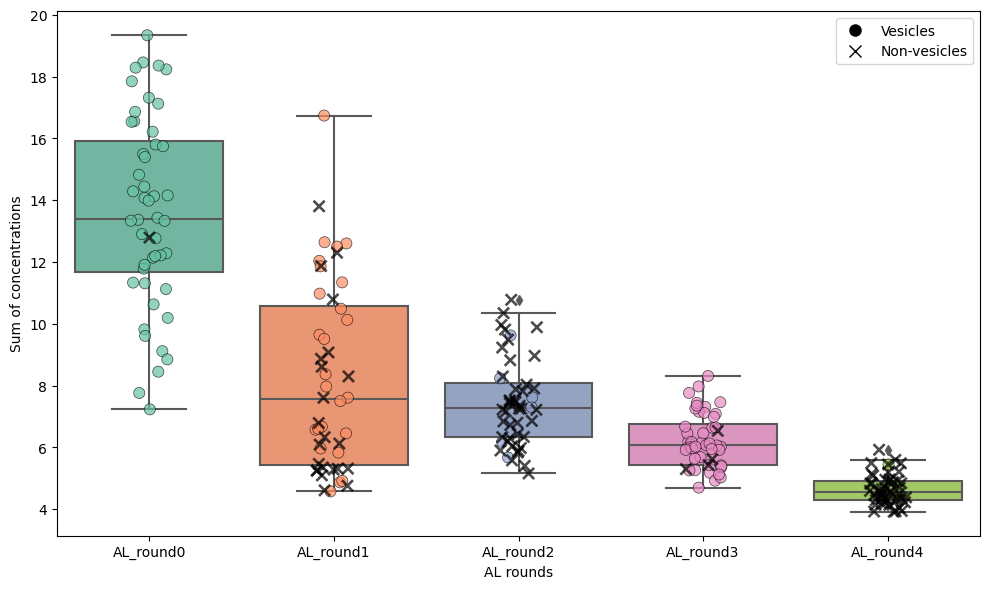

In [19]:
# See it on original scale
# Apply expm1 to the first 7 columns
df_input_update.iloc[:, :7] = df_input_update.iloc[:, :7].apply(np.expm1)

df_input_update['sum'] = df_input_update.iloc[:, :7].sum(axis=1)

# Split the DataFrame into 3 groups of 48 rows and add a 'group' column
group_labels = np.repeat([1, 2, 3, 4, 5], 48)
df_input_update['group'] = group_labels[:len(df_input_update)]

# Separate data for vesicles and non-vesicles
vesicles = df_input_update[df_input_update['num_vesicles'] == 1]
non_vesicles = df_input_update[df_input_update['num_vesicles'] == 0]

# Initialize the figure
plt.figure(figsize=(10, 6))

# Create a box plot with Seaborn
sns.boxplot(x='group', y='sum', data=df_input_update, palette='Set2', width=0.8)

# Overlay a scatter plot for vesicles
sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)

# Overlay a scatter plot for non-vesicles
sns.stripplot(x='group', y='sum', data=non_vesicles, palette='Set2', marker='x', size=8, edgecolor='black', linewidth=1.9, alpha=0.7)

# Add labels and title
plt.xlabel('AL rounds')
plt.ylabel('Sum of concentrations')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['AL_round0', 'AL_round1', 'AL_round2', 'AL_round3', 'AL_round4'])

# Add custom legend
import matplotlib.lines as mlines

vesicles_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Vesicles')
non_vesicles_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Non-vesicles')

plt.legend(handles=[vesicles_legend, non_vesicles_legend])

# Show the plot
plt.tight_layout()
plt.show()

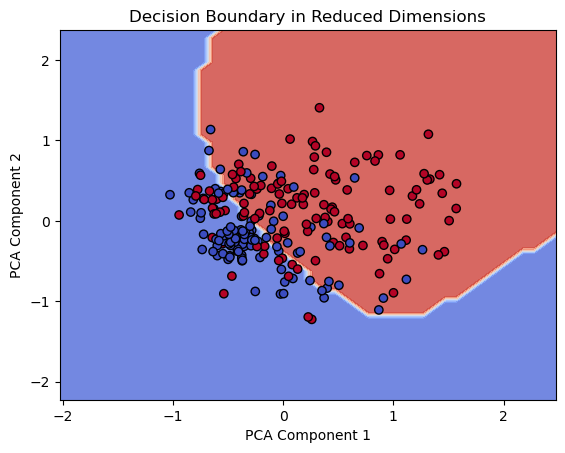

In [35]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
plt.show()


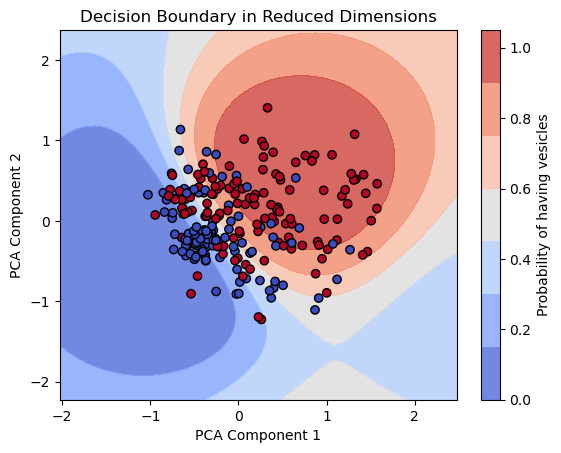

In [36]:
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
probs = model.predict_proba(grid_points_original_space)
probs_class_1 = probs[:, 1].reshape(xx.shape)

# Plot decision boundary and data points
contour = plt.contourf(xx, yy, probs_class_1, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
# Add color bar
cbar = plt.colorbar(contour)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

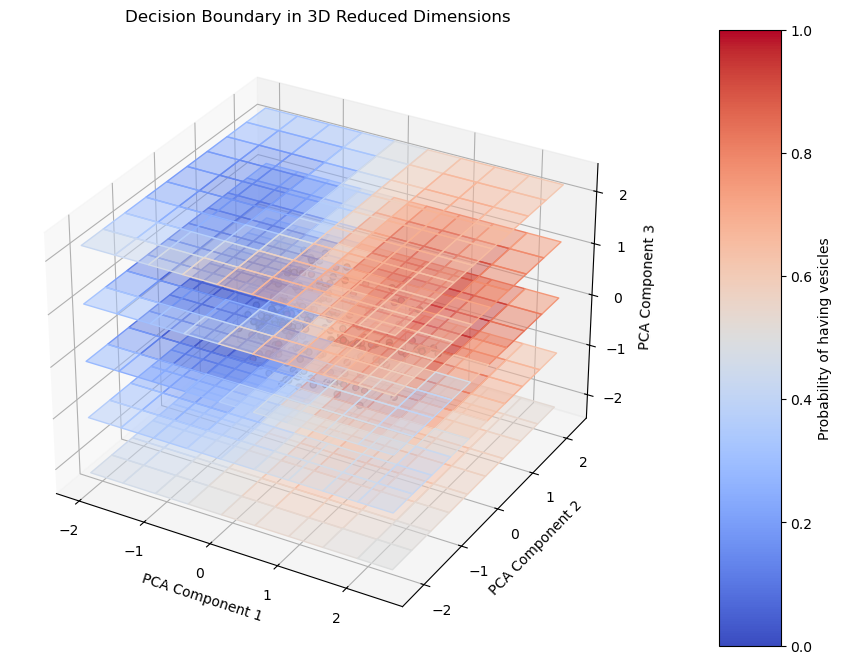

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Fit PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
z_min, z_max = X_reduced[:, 2].min() - 1, X_reduced[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot slices of the decision boundary at different z levels
z_levels = np.linspace(z_min, z_max, num=5)
norm = Normalize(vmin=0, vmax=1)

for z in z_levels:
    zz = np.full_like(xx, z)
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    grid_points_original_space = pca.inverse_transform(grid_points)
    probs = model.predict_proba(grid_points_original_space)
    probs_class_1 = probs[:, 1].reshape(xx.shape)
    
    # Plot the surface for this z slice
    surf = ax.plot_surface(xx, yy, zz, facecolors=plt.cm.coolwarm(norm(probs_class_1)), alpha=0.5, shade=False)
    
# Plot the data points
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Decision Boundary in 3D Reduced Dimensions')

# Add color bar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, aspect=10)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [38]:
pca = PCA()
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.30267977, 0.18882441, 0.16884625, 0.14530468, 0.1143296 ,
       0.05396289, 0.02605239])

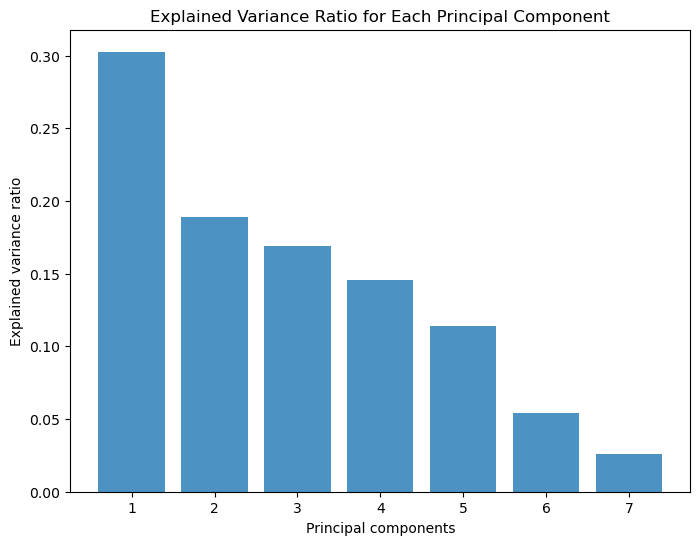

In [39]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio for each PC
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

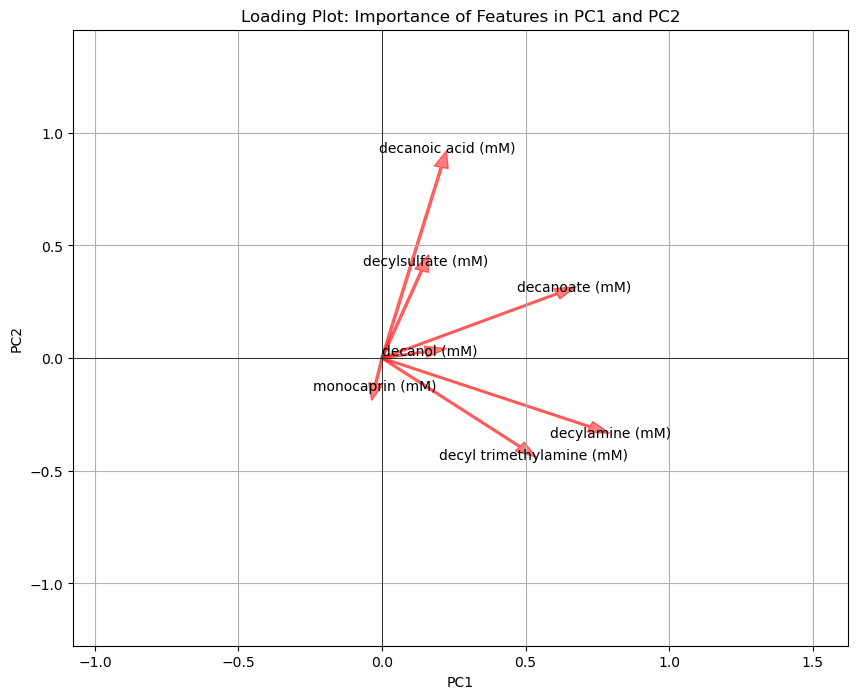

In [40]:
# Get the loadings for the first two PCs
loadings = pca.components_[:2, :]

# Feature names
feature_names = ['decanoic acid (mM)', 'decanoate (mM)',
                 'decylamine (mM)', 'decyl trimethylamine (mM)',
                 'decylsulfate (mM)', 'decanol (mM)',
                 'monocaprin (mM)']

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)

# Plot loadings with arrows
plt.figure(figsize=(10, 8))
plt.title('Loading Plot: Importance of Features in PC1 and PC2')

# Scale factor for the arrows to make them visually appealing
scale_factor = 1.1

for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * scale_factor, loadings_df.loc[feature, 'PC2'] * scale_factor,
              color='r', alpha=0.5, width=0.008, head_width=0.05)
    plt.text(loadings_df.loc[feature, 'PC1'] * scale_factor * 1.1, loadings_df.loc[feature, 'PC2'] * scale_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Set x and y limits based on PC1 and PC2 range
pc1_min, pc1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
pc2_min, pc2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
plt.xlim(pc1_min - 0.05, pc1_max + 0.05)
plt.ylim(pc2_min - 0.05, pc2_max + 0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [20]:
# model prediction

In [21]:
df_sample = pd.read_csv('df_sample_20240528.csv')

In [22]:
df_sample

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
0,0.392724,0.369573,0.120460,0.424857,0.591900,0.035454,0.230358
1,0.459205,0.685944,0.568357,0.320293,0.406413,0.154128,0.659858
2,0.206015,0.406974,0.298714,0.410124,0.436346,0.460685,0.236489
3,0.635155,0.293994,0.557038,0.137760,0.655182,0.595814,0.398491
4,0.192494,0.260856,0.159327,0.507569,0.086778,0.266699,0.450299
...,...,...,...,...,...,...,...
9999995,0.498363,0.577140,0.605472,0.221862,0.160296,0.612715,0.429254
9999996,0.679523,0.145563,0.451870,0.588802,0.008938,0.196234,0.431717
9999997,0.685342,0.660538,0.151012,0.514961,0.317437,0.315391,0.187897
9999998,0.309813,0.625423,0.496721,0.346873,0.114644,0.278361,0.576904


In [24]:
batch_size = 100000  # Define a suitable batch size
num_batches = len(df_sample) // batch_size

pred_probs = []

start_time = time.time()

for i in range(num_batches + 1):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_sample))
    
    if start_idx >= len(df_sample):
        break
    
    batch = df_sample.values[start_idx:end_idx]
    pred_probs_batch = model.predict_proba(batch)
    pred_probs.extend(pred_probs_batch)

# Convert the list of probabilities back to a numpy array if needed
pred_probs = np.array(pred_probs)

end_time = time.time()

running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 41.917309045791626 seconds


In [30]:
# Extract the second column
second_column = pred_probs[:, 1]

# Transform values: >0.5 to 1, else 0
transformed = np.where(second_column > 0.5, 1, 0)

# Calculate the percentage of 1s
percentage_of_ones = np.mean(transformed) * 100

print(f"Percentage of 1s: {percentage_of_ones:.4f}%")

Percentage of 1s: 0.0000%


In [28]:
transformed

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
second_column.max()

0.5356346329476764

In [34]:
len(transformed[transformed==1])

1

(array([9.415119e+06, 4.463870e+05, 9.743300e+04, 2.774600e+04,
        8.999000e+03, 3.023000e+03, 9.510000e+02, 2.710000e+02,
        6.700000e+01, 4.000000e+00]),
 array([2.91755948e-04, 5.38260436e-02, 1.07360331e-01, 1.60894619e-01,
        2.14428907e-01, 2.67963194e-01, 3.21497482e-01, 3.75031770e-01,
        4.28566058e-01, 4.82100345e-01, 5.35634633e-01]),
 <BarContainer object of 10 artists>)

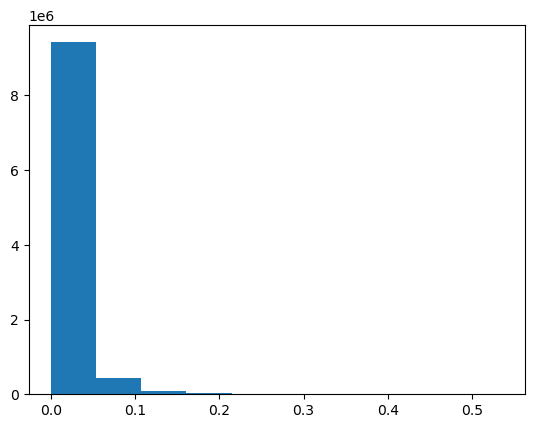

In [33]:
plt.hist(second_column)

In [35]:
def cal_vesicles_per(pred_probs):
    # Extract the second column
    second_column = pred_probs[:, 1]
    plt.hist(second_column)
    
    # Transform values: >0.5 to 1, else 0
    transformed = np.where(second_column > 0.5, 1, 0)
    
    # Calculate the percentage of 1s
    percentage_of_ones = np.mean(transformed) * 100
    
    print(f"Percentage of 1s: {percentage_of_ones:.4f}%")
    return percentage_of_ones

Percentage of 1s: 0.0000%


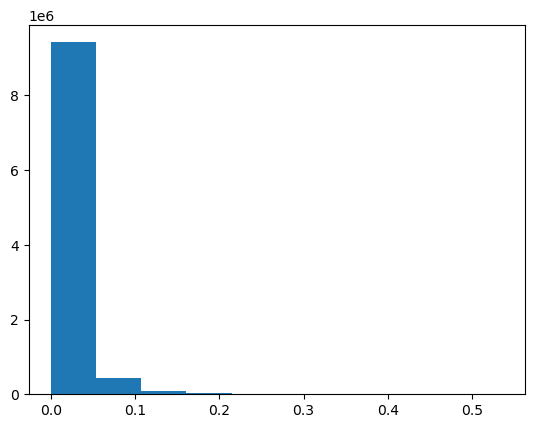

In [36]:
p4 = cal_vesicles_per(pred_probs)

In [39]:
df_sample = pd.read_csv('df_sample_20240520.csv')
df_sample = df_sample.iloc[:, 0:7]
batch_size = 100000  # Define a suitable batch size
num_batches = len(df_sample) // batch_size

pred_probs = []

start_time = time.time()

for i in range(num_batches + 1):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_sample))
    
    if start_idx >= len(df_sample):
        break
    
    batch = df_sample.values[start_idx:end_idx]
    pred_probs_batch = model.predict_proba(batch)
    pred_probs.extend(pred_probs_batch)

# Convert the list of probabilities back to a numpy array if needed
pred_probs = np.array(pred_probs)

end_time = time.time()

running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 41.67181086540222 seconds


Percentage of 1s: 37.0253%


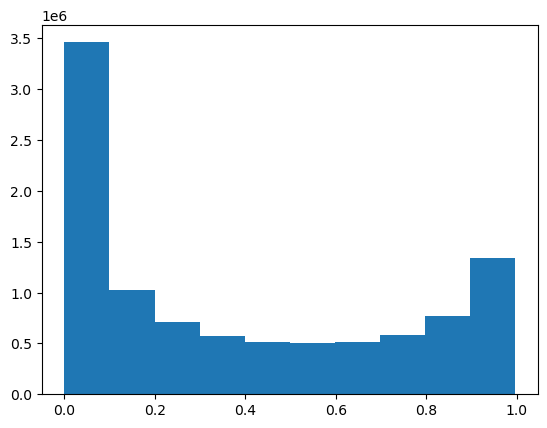

In [40]:
p3 = cal_vesicles_per(pred_probs)

In [41]:
df_sample=pd.read_csv('df_sample_20240512.csv')

In [43]:

batch_size = 100000  # Define a suitable batch size
num_batches = len(df_sample) // batch_size

pred_probs = []

start_time = time.time()

for i in range(num_batches + 1):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_sample))
    
    if start_idx >= len(df_sample):
        break
    
    batch = df_sample.values[start_idx:end_idx]
    pred_probs_batch = model.predict_proba(batch)
    pred_probs.extend(pred_probs_batch)

# Convert the list of probabilities back to a numpy array if needed
pred_probs = np.array(pred_probs)

end_time = time.time()

running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 41.6929190158844 seconds


Percentage of 1s: 74.0484%


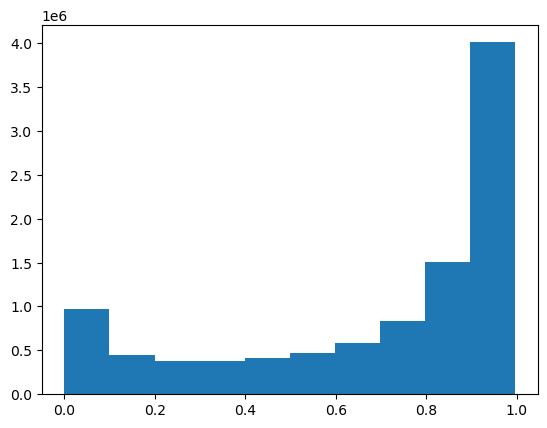

In [44]:
p2 = cal_vesicles_per(pred_probs)

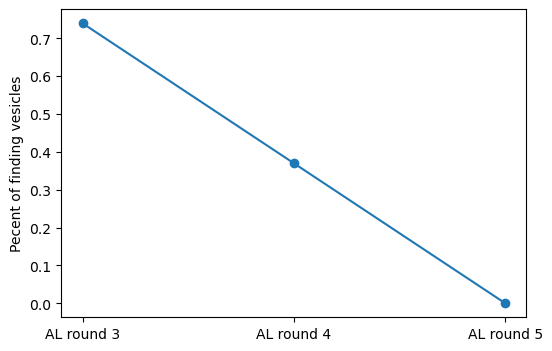

In [46]:
# p1 = 0.84263
p2 = 0.74
p3 = 0.37
p4 = 0.0
p = [ p2, p3, p4]

# Plot the trend
plt.figure(figsize=(6, 4))
plt.plot(p, marker='o')

# Add labels and title
# plt.xlabel('AL round')
plt.ylabel('Pecent of finding vesicles')
plt.xticks([0, 1, 2], ['AL round 3', 'AL round 4', 'AL round 5'])  # Label the x-axis ticks
plt.show()

In [47]:
# do sample on AL round3 input  (half of the original)

In [52]:
df_sample = pd.read_csv('df_sample_20240520.csv')

In [53]:
df_sample = df_sample.iloc[:,0:7]
batch_size = 100000  # Define a suitable batch size
num_batches = len(df_sample) // batch_size

pred_probs = []

start_time = time.time()

for i in range(num_batches + 1):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_sample))
    
    if start_idx >= len(df_sample):
        break
    
    batch = df_sample.values[start_idx:end_idx]
    pred_probs_batch = model.predict_proba(batch)
    pred_probs.extend(pred_probs_batch)

# Convert the list of probabilities back to a numpy array if needed
pred_probs = np.array(pred_probs)

end_time = time.time()

running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 41.86826133728027 seconds


In [54]:
entropy_value = cal_entropy(pred_probs)
# Get indices of the first 48 samples with highest entropy
top_indices = np.argsort(entropy_value)[::-1][:48]
top_indices

array([2466279, 4417958, 6533013, 1760459, 3160678, 8673685, 7535673,
       3810960, 9413456, 6071211, 8544296, 5113436, 9260219, 5568544,
       3577012, 3531215, 4484889, 1313542, 4798241, 1845646, 6056373,
       2971295, 6037886, 8525353, 1891826, 8532636, 3574941, 3246142,
       1978035, 3984029, 6012474,  667153, 6195231, 6273027, 8734654,
       7371193, 5326082, 1554671, 9254991, 4775916, 6177286, 5462712,
       7983382, 1868384, 8223523,  394757, 6000690, 6139074])

In [55]:
df_prob = pd.DataFrame(pred_probs)
df_prob.to_csv('pred_prob_20240603.csv', index=False)

In [57]:
candidates = df_sample.iloc[top_indices]
original_scale_df = np.expm1(candidates)
original_scale_df

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
2466279,2.313013,2.270580,1.858176,0.645437,0.048689,0.046288,0.261030
4417958,2.153331,1.076237,2.183102,0.610729,0.572942,0.312744,0.177431
6533013,2.200160,0.013734,1.317408,0.145357,1.708210,0.488050,0.438262
1760459,1.921273,0.374624,0.572201,2.120860,0.583905,0.262502,0.057909
3160678,1.123525,1.709131,2.375313,0.615301,0.951851,0.460753,0.062773
8673685,1.763430,0.636539,0.823840,1.220863,0.775763,0.382171,0.201510
7535673,1.493804,0.110668,2.281451,1.083054,1.037484,0.400443,0.446071
3810960,2.048055,0.919569,1.306241,1.496506,0.268202,0.029947,0.174751
9413456,1.428008,0.184929,0.654673,0.567425,1.567798,0.251225,0.006928
6071211,0.995996,0.973835,0.001704,1.960814,0.816564,0.494493,0.239221


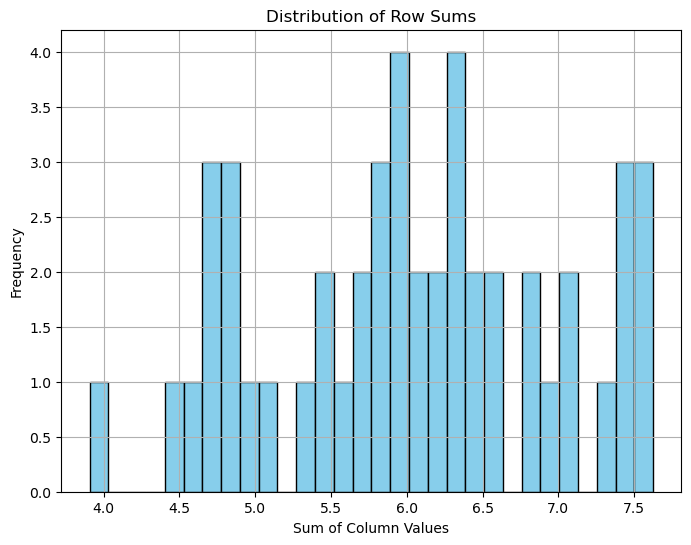

In [58]:
row_sums = original_scale_df.sum(axis=1)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(row_sums, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Row Sums')
plt.xlabel('Sum of Column Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [59]:
candidates.to_csv('candidates_20240603.csv', index = False)

### Create dispense volume

In [60]:
original_scale_df.to_csv('original_scale_df_GPC_20240603.csv', index=False)

In [67]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=True)
len(dispense_df)

48

In [68]:
def clean_column_name(name):
    return name.replace("_Concentration (mM)", "_Concentration ")

# Apply the function to the column names
dispense_df.columns = [clean_column_name(col) for col in dispense_df.columns]
dispense_df.columns

Index(['decanoic acid_Concentration  (50 mM)',
       'decanoic acid_Concentration  (10 mM)',
       'decanoic acid_Concentration  (2 mM)',
       'decanoate_Concentration  (50 mM)', 'decanoate_Concentration  (10 mM)',
       'decanoate_Concentration  (2 mM)', 'decylamine_Concentration  (50 mM)',
       'decylamine_Concentration  (10 mM)', 'decylamine_Concentration  (2 mM)',
       'decyl trimethylamine_Concentration  (50 mM)',
       'decyl trimethylamine_Concentration  (10 mM)',
       'decyl trimethylamine_Concentration  (2 mM)',
       'decylsulfate_Concentration  (50 mM)',
       'decylsulfate_Concentration  (10 mM)',
       'decylsulfate_Concentration  (2 mM)', 'decanol_Concentration  (15 mM)',
       'decanol_Concentration  (3 mM)', 'monocaprin_Concentration  (10 mM)',
       'monocaprin_Concentration  (2 mM)'],
      dtype='object')

In [69]:
dispense_df.to_csv('dispense_df_GPC_20240603.csv', index=False)

In [70]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240531/dispense_df_20240603.xlsx') as writer:
    # Write df_repeated to sheet Plate1
    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_repeated to sheet Plate2
    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)

In [71]:
dispense_df

,decanoic acid_Concentration (50 mM),decanoic acid_Concentration (10 mM),decanoic acid_Concentration (2 mM),decanoate_Concentration (50 mM),decanoate_Concentration (10 mM),decanoate_Concentration (2 mM),decylamine_Concentration (50 mM),decylamine_Concentration (10 mM),decylamine_Concentration (2 mM),decyl trimethylamine_Concentration (50 mM),decyl trimethylamine_Concentration (10 mM),decyl trimethylamine_Concentration (2 mM),decylsulfate_Concentration (50 mM),decylsulfate_Concentration (10 mM),decylsulfate_Concentration (2 mM),decanol_Concentration (15 mM),decanol_Concentration (3 mM),monocaprin_Concentration (10 mM),monocaprin_Concentration (2 mM)
2466279,9.3,0.0,0.0,9.1,0.0,0.0,7.4,0.0,0.0,0.0,12.9,0.0,0.0,0.0,4.9,0.0,3.1,5.2,0.0
4417958,8.6,0.0,0.0,4.3,0.0,0.0,8.7,0.0,0.0,0.0,12.2,0.0,0.0,11.5,0.0,4.2,0.0,0.0,17.7
6533013,8.8,0.0,0.0,0.0,0.0,1.4,5.3,0.0,0.0,0.0,0.0,14.5,6.8,0.0,0.0,6.5,0.0,8.8,0.0
1760459,7.7,0.0,0.0,0.0,7.5,0.0,0.0,11.4,0.0,8.5,0.0,0.0,0.0,11.7,0.0,0.0,17.5,0.0,5.8
3160678,4.5,0.0,0.0,6.8,0.0,0.0,9.5,0.0,0.0,0.0,12.3,0.0,0.0,19.0,0.0,6.1,0.0,0.0,6.3
8673685,7.1,0.0,0.0,0.0,12.7,0.0,0.0,16.5,0.0,4.9,0.0,0.0,0.0,15.5,0.0,5.1,0.0,4.0,0.0
7535673,6.0,0.0,0.0,0.0,0.0,11.1,9.1,0.0,0.0,4.3,0.0,0.0,4.1,0.0,0.0,5.3,0.0,8.9,0.0
3810960,8.2,0.0,0.0,0.0,18.4,0.0,5.2,0.0,0.0,6.0,0.0,0.0,0.0,5.4,0.0,0.0,2.0,0.0,17.5
9413456,5.7,0.0,0.0,0.0,0.0,18.5,0.0,13.1,0.0,0.0,11.3,0.0,6.3,0.0,0.0,0.0,16.7,0.0,0.7
6071211,0.0,19.9,0.0,0.0,19.5,0.0,0.0,0.0,0.2,7.8,0.0,0.0,0.0,16.3,0.0,6.6,0.0,4.8,0.0
